# CoExDBSCAN - Density-Based Clustering with Constrained Expansion

We introduce two user-defined parameters to the original DBSCAN algorithm. One to define the dimensions of the subspace to be used to discover density-based clusters, and one to define the dimensions of the subspace to be used to apply constraints to the cluster expansion of DBSCAN.

We modify the cluster expansion step in the original DBSCAN algorithm to be restricted to user-defined constraints. We propose a generic constraint to discover correlated structures in large datasets.

Finally, we provided results of thorough experimental studies on synthetic and real-world datasets and demonstrate, that our algorithm is especially suited for spatio-temporal data, where one subspace of features defines the spatial extent of the data and another correlations between features.

In [1]:
import pandas as pd
import shlex, subprocess

from statistics import stdev

import numpy as np
np.random.seed(1234)

import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

We compared the results of our algorithm with the results from DBSCAN and CASH for different existing popular reference datasets, for example the Iris flower dataset and the artificial datasets used for the verification of the CURE algorithm and also our own generated synthetic dataset.

Our synthetic dataset contains 3,000 points with three dimensions and three classes, 1,000 points per class.

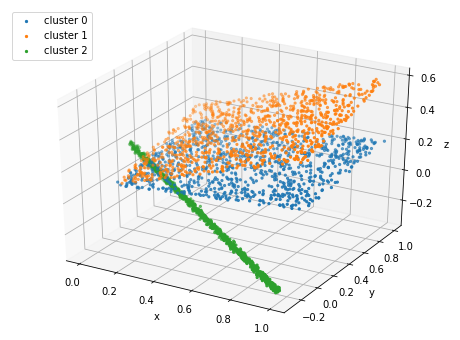

In [2]:
def y(x, m, b):
    return m*x + b

def z(a, x, b, y, c):
    return a*x + b*y + c

a_xy = np.random.uniform(size=(1000,2))
a_z = [z(0.1, x, 0.1, y, 0) for x,y in a_xy]

b_x = np.linspace(0, 1, 1000)
b_y = [y(x, -0.5, 0.2) + np.random.normal(0, 0.01) for x in b_x]
b_z = [y(x, -0.5, 0.2) + np.random.normal(0, 0.01) for x in b_x]

c_xy = np.random.uniform(size=(1000,2))
c_z = [z(0.4, x, 0.2, y, 0) for x,y in c_xy]

data = np.vstack([np.c_[a_xy, a_z],
                  np.c_[c_xy, c_z],
                  np.c_[b_x, b_y, b_z]])

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter3D(data[:1000, 0], data[:1000, 1], data[:1000, 2], marker=".", label="cluster 0")
ax.scatter3D(data[1000:2000, 0], data[1000:2000, 1], data[1000:2000, 2], marker=".", label="cluster 1")
ax.scatter3D(data[2000:, 0], data[2000:, 1], data[2000:, 2], marker=".", label="cluster 2")
plt.legend(loc=2);

Following defines a function for plotting the results.

In [3]:
from matplotlib.markers import MarkerStyle
from sklearn.metrics import adjusted_rand_score

def plot_clustering(data, clustering, labels_true=None):
    fig = plt.figure(figsize=(16, 4))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    
    labels = np.full(len(data), -1)

    #markers = list(MarkerStyle.markers.keys())[1:-4]

    if "labels_" in dir(clustering):
        labels = clustering.labels_
    elif "get_clusters" in dir(clustering):
        for l, c in enumerate(clustering.get_clusters()):
            labels[c] = l
    else:
        print("ERROR")
        return

    for i, l in enumerate(np.unique(labels)):
        if l == -1:
            legend = "noise"
        else:
            legend = "cluster {}".format(l)

        c = data[labels== l]

        if l == -1:
            ax1.scatter3D(c[:,0], c[:,1], c[:,2], marker='.', c='gray', alpha=0.1, label=legend)
            ax2.scatter(c[:,0], c[:,2], marker='.', c='gray', alpha=0.1, label=legend)
        else:
            ax1.scatter3D(c[:,0], c[:,1], c[:,2], marker='.', label=legend)
            ax2.scatter(c[:,0], c[:,2], marker='.', label=legend)

    plt.legend(loc=2)

    counts = np.unique(labels, return_counts=True)
    cluster_count = dict(enumerate(counts[1], start=int(counts[0][0])))
    
    print(f'#cluster count: {cluster_count}')
    
    if labels_true is not None:
        ari = adjusted_rand_score(labels_true, labels)
        print(f'Adjusted Rand Index {ari}')
        
    return fig

Following is the implementation of the CoExDBSCAN algorithm.

In [4]:
# from sklearn.neighbors import DistanceMetric, KDTree

from scipy.spatial import KDTree
from sklearn.linear_model import LinearRegression
from sklearn import metrics

class COEXDBSCAN(object):
    def __init__(self, eps=0.5, min_samples=5, delta=0.1, sdim=(0,), cdim=(0,), dist='euclidean'):
        self.eps = eps
        self.min_samples = min_samples
        self.delta = delta
        self.sdim = sdim
        self.cdim = cdim
        self.dist = dist
    
    def get_params(self):
        return {'eps': self.eps,
                'min_samples': self.min_samples,
                'sdim': self.sdim,
                'cdim': self.cdim,
                'dist': self.dist,
               }
    
    def fit(self, data):
        eps = self.eps
        minPts = self.min_samples
        delta = self.delta
        sdim = self.sdim
        cdim = self.cdim
        dist = self.dist
        
        points = data.copy()

        tree = KDTree(points[:,sdim])
        neighbours = tree.query_ball_point(points[:,sdim], eps)
        
#         dist = DistanceMetric.get_metric(dist)
#         tree = KDTree(points[:,sdim])
#         neighbours = tree.query_radius(points[:,sdim], r=eps)

        unclassified = np.inf
        noise = -1
        nextLabel = noise

        labels = np.full(points.shape[0], unclassified)
        
        for idx in range(points.shape[0]):
            if labels[idx] != unclassified:
                continue
            if len(neighbours[idx]) < minPts:
                labels[idx] = noise
                continue
                
            seeds = set(neighbours[idx])
            
            nextLabel += 1
            
            labels[idx] = nextLabel
            seeds = set(neighbours[idx])
            seeds.remove(idx)
                
            while len(seeds) > 0:
                seed = seeds.pop()
                if labels[seed] != unclassified:
                    continue

                cluster_points = points[labels == nextLabel][:,cdim]
                lm = LinearRegression()
                X = cluster_points[:,0].reshape(-1,1)
                y = cluster_points[:,1]
                model = lm.fit(X,y)
                y_p = model.predict(X)
                mse = metrics.mean_squared_error(y,y_p)

                labels[seed] = nextLabel
                if len(neighbours[seed]) < minPts:
                    continue

                cluster_points = points[labels == nextLabel][:,cdim]
                lm = LinearRegression()
                X = cluster_points[:,0].reshape(-1,1)
                y = cluster_points[:,1]
                model = lm.fit(X,y)
                y_p = model.predict(X)
                mse_new = metrics.mean_squared_error(y,y_p)
                
                if np.abs(mse - mse_new) < delta:
                    seeds.update(neighbours[seed])
                
        self.labels_ = labels.astype(int)
        return self

## CoExDBSCAN Results for the Synthetic Data

The threshold for the change of the mean squared error regression loss has been set to 9 · 10 −6 , according to empirical tests. The ε and minPts parameters
have been determined by a grid search on the parameter space for ε in the interval [0.01, 0.2] with a step size of 0.01 and minPts in the range of [3, 100] with a step size of 1.

The next figure shows the best qualitative result, with three clusters, fewest noise points and the maximum amount of points in each cluster.

By comparing the CoExDBSCAN results visually to the original DBSCAN results, it is apparent, that the CoExDBSCAN clustering result better captures the inherent structure of the dataset. Apart from the overlapping area, the correlated data points in each of the three generated point samples have been assigned to three distinct
clusters.

#cluster count: {-1: 18, 0: 1974, 1: 540, 2: 468}
Adjusted Rand Index 0.2318960616943305


Text(0.5, 0.98, 'CoExDBSCAN, epsilon=0.1, minPts=20, ARI=0.232')

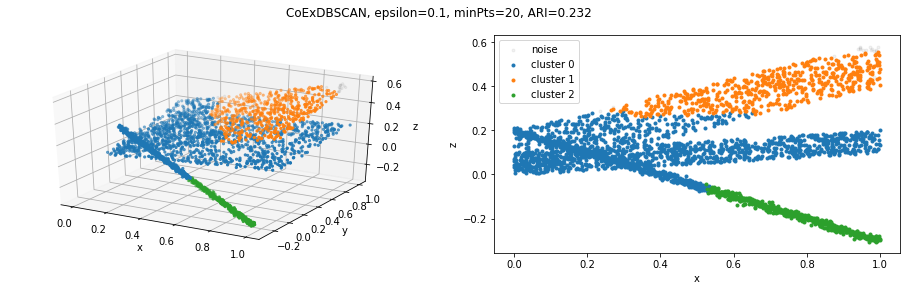

In [5]:
from sklearn.cluster import DBSCAN, OPTICS
from hdbscan import HDBSCAN

#from sklearn.preprocessing import StandardScaler

labels_true = np.array([0] * 1000 + [1] * 1000 + [2] * 1000)

eps = 0.1
minPts = 20
delta = 9e-6

X = data

# clustering = DBSCAN(eps=0.1, min_samples=20).fit(X)
clustering = COEXDBSCAN(eps=eps, min_samples=minPts, delta=delta,
                        sdim=(0,1,2), cdim=(0,2)).fit(X)

f = plot_clustering(data, clustering, labels_true)
f.suptitle(r'CoExDBSCAN, epsilon='+str(eps)+', minPts='+str(minPts)+', ARI=0.232', fontsize=12)

## DBSCAN Results for the Synthetic Data

The next figure shows the qualitative best DBSCAN clustering result, with three clusters, fewest noise points and the maximum amount of points in each cluster.

It becomes apparent, that with a higher radius ε, the DBSCAN algorithm is now able to expand into the whole dataset, while the number of ε-neighborhood points determines the amount of noise and closeness of the clusters.

#cluster count: {-1: 421, 0: 2132, 1: 155, 2: 292}
Adjusted Rand Index 0.10373468846730777


Text(0.5, 0.98, 'DBSCAN, epsilon=0.17, minPts=98, ARI=0.104')

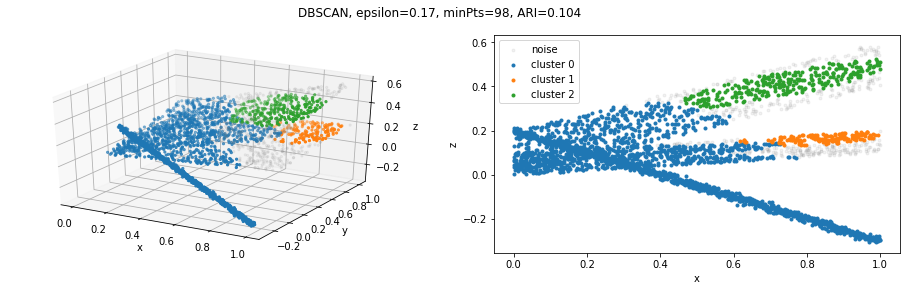

In [6]:
labels_true = np.array([0] * 1000 + [1] * 1000 + [2] * 1000)

eps = 0.17
minPts = 98

X = data

clustering = DBSCAN(eps=eps, min_samples=minPts).fit(X)

f = plot_clustering(data, clustering, labels_true)
f.suptitle(r'DBSCAN, epsilon='+str(eps)+', minPts='+str(minPts)+', ARI=0.104', fontsize=12)

## CASH Results for the Synthetic Data

For this comparison we use the ELKI Data Mining Framework.

https://elki-project.github.io/

The next figure illustrates the qualitative best clustering result for CASH on our synthetic dataset with the parameters minPts = 70, maxLevel = 1 and jitter = 0.001, with five clusters and the maximum amount of points in each cluster.

The lowest number of clusters in the parameter space is five, and while the best qualitative results captures proportions of the correlated structures well, it performs poorer than CoExDBSCAN in terms of our evaluation metrics.

#cluster count: {0: 1157, 1: 935, 2: 746, 3: 111, 4: 51}
Adjusted Rand Index 0.23113422621478122


Text(0.5, 0.98, 'CASH, maxLevel=1, minPts=70, jitter=0.001, ARI=0.231')

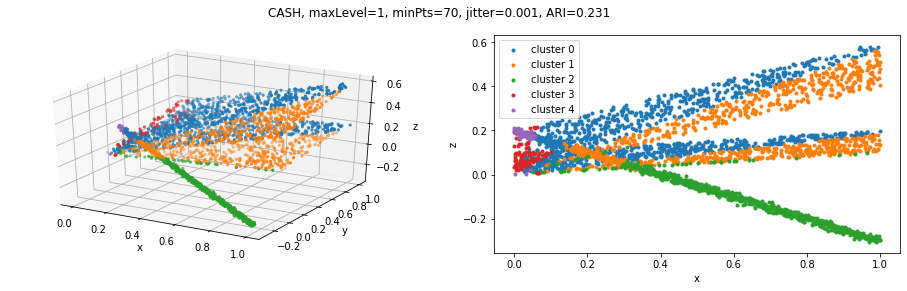

In [7]:
mp = 70
ml = 1
ji = 0.001

args = ['./elki-cli.sh', str(mp), str(ml), str(ji)]

p = subprocess.Popen(args, cwd='./elki-0.7.5', stdout=subprocess.PIPE)
output, error = p.communicate()
cash = np.fromstring(output.decode("utf-8"), dtype=int, sep=' ', count=3000)

class labels(object):
    def __init__(self, labels):
        self.labels_ = labels
        
f = plot_clustering(data, labels(cash), labels_true)
f.suptitle(r'CASH, maxLevel='+str(ml)+', minPts='+str(mp)+', jitter='+str(ji)+', ARI=0.231', fontsize=12)

## Results for Popular Reference Datasets

Reference datasets can be found here.

https://github.com/deric/clustering-benchmark

!Note: Parameters have to be adjusted for the purpose of the analysis.!

In general, CoExDBSCAN can operate on parameters that allow to expand into the whole dataset and, while avoiding the degenerated case of single, big clusters.

In [8]:
from scipy.io import arff

diamond, meta = arff.loadarff('data/diamond.arff')
cure, meta = arff.loadarff('data/cure.arff')

X = np.array(cure[['x','y']].tolist())

The next figure shows a DBSCAN clustering for one of the synthetic datasets that has been used in the CURE algorithm verification runs.

(array([-1,  0,  1]), array([  18, 3325,  857]))

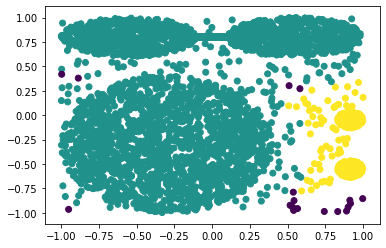

In [9]:
clustering = DBSCAN(eps=0.2, min_samples=50).fit(X)
plt.scatter(X[:,0],X[:,1],c=clustering.labels_)
np.unique(clustering.labels_, return_counts=True)

The next figure shows a CoExDBSCAN clustering for one of the synthetic datasets that has been used in the CURE algorithm verification runs.

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]),
 array([  49, 1134,  326,  295,   32,   18,    2,    7,  431,  423, 1483]))

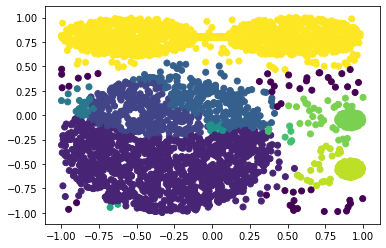

In [10]:
clustering = COEXDBSCAN(eps=0.2, min_samples=50, delta=1e-5,
                        sdim=(0,1), cdim=(0,1)
                       ).fit(X)
plt.scatter(X[:,0],X[:,1],c=clustering.labels_)
np.unique(clustering.labels_, return_counts=True)

In [11]:
X = np.array(diamond[['x','y']].tolist())

The next figure shows a DBSCAN clustering for the diamond synthetic datasets.

(array([0]), array([3000]))

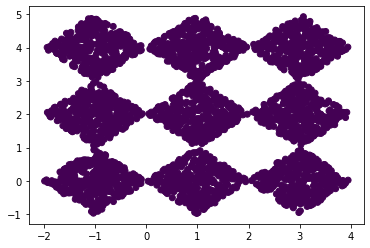

In [12]:
clustering = DBSCAN(eps=0.5, min_samples=50).fit(X)
plt.scatter(X[:,0],X[:,1],c=clustering.labels_)
np.unique(clustering.labels_, return_counts=True)

The next figure shows a CoExDBSCAN clustering for the diamond synthetic datasets.

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50]),
 array([ 19,  55, 118,  87,  32,  25,  22,  25,  70,  56,  57,  83,  32,
         29,  38, 121, 121,  30,  40,  75,  82,  97,  55, 127,  42,  51,
         59,  30,  93,  87,  76,  47,   8,  18, 102,  51, 151,  13,  11,
         31, 123,  51,  56,  59,  17,  74,  42,  93,  47,  22,  49,   1]))

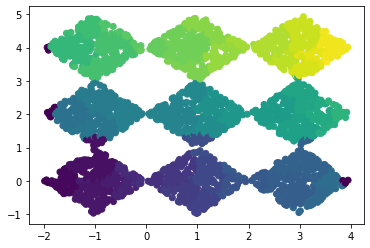

In [13]:
clustering = COEXDBSCAN(eps=0.5, min_samples=50, delta=1e-5,
                        sdim=(0,1), cdim=(0,1)
                       ).fit(X)
plt.scatter(X[:,0],X[:,1],c=clustering.labels_)
np.unique(clustering.labels_, return_counts=True)

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()

The next figure shows a DBSCAN clustering for the Iris flower dataset.

#cluster count: {0: 50, 1: 100}
Adjusted Rand Index 0.5681159420289855


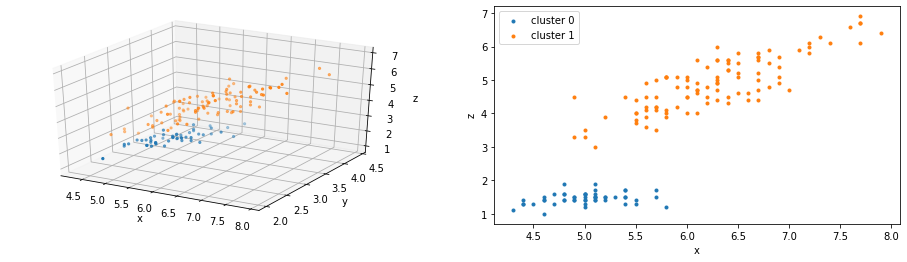

In [15]:
X = iris.data

clustering = DBSCAN(eps=1, min_samples=5).fit(X)

f = plot_clustering(X, clustering, iris.target)

The next figure shows a CoExDBSCAN clustering for the Iris flower dataset.

#cluster count: {0: 50, 1: 63, 2: 26, 3: 11}
Adjusted Rand Index 0.577545872409068


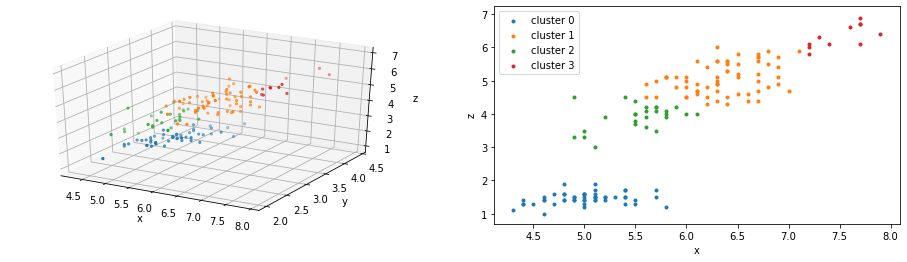

In [16]:
clustering = COEXDBSCAN(eps=1, min_samples=5,
                        delta=5e-4,
                        sdim=(0,1,2,3), cdim=(0,2)
                       ).fit(X)

f = plot_clustering(X, clustering, iris.target)

## Clustering Results for Real Climatology Data

Our real-world dataset consists of spectral data gathered from Metop-A and Metop-B satellites that have been processed for the water vapour H2O mixing ratio
and water isotopologue δD depletion for air masses at 5km height with most sensitivity. The water isotopologue in question is HDO, which differs only in the isotopic composition compared to H2O.

Isotopologues of atmospheric water vapour can make a significant contribution for a better understanding of atmospheric water transport, because different water transport pathways leave a distinctive isotopologue fingerprint.

In [17]:
import geopandas

We read in the data first.

We already applied filters for high quality measurements and did the transformation.

In [18]:
f = 'data/METOPAB_20170611_global_morning.parquet'

lal = 25 # latitude low boundery
lah = 45  # latitude high boundery
lol = 9 #-45 # longitude low boundery
loh = 30 #60  # longitude high boundery

df = pd.read_parquet(f)
df.head()

,lat,lon,h2o,delD,h2o_log,h2o_delD,lon_t,lat_t,h2o_t,delD_t,labels
0,44.117752,57.937492,2320.576670,-220.412198,7.749571,-511483.404970,83.187885,88.235504,38.747855,-11.020610,0.0
1,43.848461,57.897385,2959.674755,-217.365756,7.992835,-643331.939369,83.508241,87.696922,39.964173,-10.868288,0.0
2,43.264042,59.547504,1169.272540,-268.057667,7.064137,-313432.468664,86.725346,86.528084,35.320685,-13.402883,0.0
3,43.647926,57.868736,3262.532849,-204.352931,8.090259,-666708.150044,83.747029,87.295853,40.451296,-10.217647,0.0
4,43.378635,57.834358,3319.783083,-213.728017,8.107655,-709530.655735,84.071588,86.757271,40.538274,-10.686401,0.0


### DBSCAN

The next figure shows a qualitative good example using DBSCAN, with parameters ε = 10 and minPts = 200.

DBSCAN has identified three clusters that are dense in the full space of the scaled variables lat, lon, H2O and δD. Moreover, two of the identified clusters
(green and orange color in the figure) indicate some correlation in the {lon(H2O), δD} and {H2O, H2O · δD} value space, while at the same time are located geographically close.

In [19]:
# clustering in the transformed space
X = df[['lon_t','lat_t','h2o_t','delD_t']].values

clustering = DBSCAN(eps=10, min_samples=200).fit(X)

labels = clustering.labels_

unique, counts = np.unique(labels, return_counts=True)
d = dict(zip(unique, counts))
noise = d.get(-1)
if noise:
    del d[-1]

r = {"clusters": len(d),
     "min": min(d.values()) if len(d) > 0 else 0,
     "max": max(d.values()) if len(d) > 0 else 0,
     "std": stdev(d.values()) if len(d) > 1 else 0,
     "noise": noise,
     "lat_min": lal,
     "lat_max": lah,
     "lon_min": lol,
     "lon_max": loh,
    }

print(r)

{'clusters': 3, 'min': 1170, 'max': 32318, 'std': 17116.882776954455, 'noise': 803, 'lat_min': 25, 'lat_max': 45, 'lon_min': 9, 'lon_max': 30}


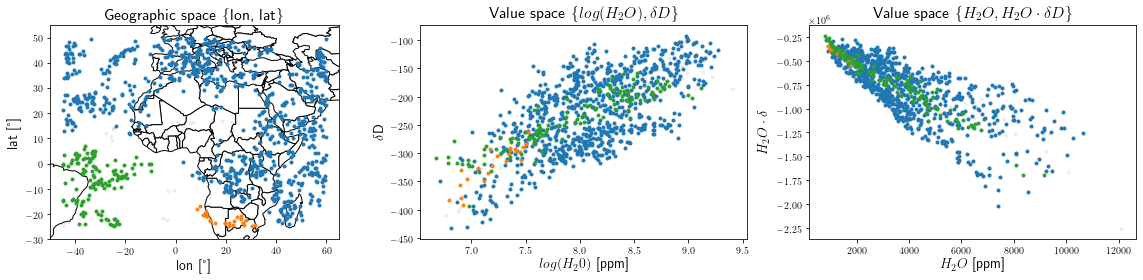

In [20]:
labels = clustering.labels_

df['labels'] = labels

df_sample = df.sample(n=1000, random_state=1)

grouped = df.sample(n=1000, random_state=1).groupby('labels')

matplotlib.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(16, 4), tight_layout=True)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax1 = fig.add_subplot(1, 3, 1) 
ax1.set_title("Geographic space \{lon, lat\}", fontsize=16)
ax1.set_xlabel('lon [\N{DEGREE SIGN}]', fontsize=14)
ax1.set_ylabel('lat [\N{DEGREE SIGN}]', fontsize=14)
ax1.set_xlim(-50,65)
ax1.set_ylim(-30,55)

ax2 = fig.add_subplot(1, 3, 2) 
ax2.set_title(r"Value space $\{log(H_2O), \delta D\}$", fontsize=16)
ax2.set_xlabel(r"$log(H_20)$ [ppm]", fontsize=14)
ax2.set_ylabel(r"$\delta$D", fontsize=14)

ax3 = fig.add_subplot(1, 3, 3) 
ax3.set_title(r"Value space $\{H_2O, H_2O \cdot \delta D\}$", fontsize=16)
ax3.set_xlabel(r"$H_2O$ [ppm]", fontsize=14)
ax3.set_ylabel(r"$H_2O \cdot \delta$ ", fontsize=14)
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for name, group in grouped:
    if name == -1:
        world.plot(ax=ax1, color='white', edgecolor='black')
        ax1.scatter(group.lon, group.lat, marker='.', c='gray', alpha=0.1)
        ax2.scatter(group.h2o_log, group.delD, marker='.', c='gray', alpha=0.1)
        ax3.scatter(group.h2o, group.h2o*group.delD, marker='.', c='gray', alpha=0.1)
    else:
        ax1.scatter(group.lon, group.lat, marker='.')
        ax2.scatter(group.h2o_log, group.delD, marker='.')
        ax3.scatter(group.h2o, group.h2o*group.delD, marker='.')

### CoExDBSCAN

The next figure shows the results using the CoExDBSCAN algorithm.

Compared to DBSCAN we have identified a significant higher number of clusters, while keeping the same ε radius and minPts neighborhood points.
All clusters are geographically close and correlated in either the {lon(H2O), δD} or {H2O, H2O · δD} value space. By incorporating a threshold for the change of the mean squared error regression loss as constraint in the cluster expansion step and explicitly defining spatial and constraint dimension, we can keep the DBSCAN
parameters that allow to explore the full dataset, but still be able to explore more fine-grained structures, even with highly overlapping data points.

In [21]:
# clustering in the transformed space
X = df[['lon_t','lat_t','h2o_t','delD_t']].values

clustering = COEXDBSCAN(eps=10, min_samples=200,
                        delta=1e-5,
                        sdim=(0,1), cdim=(2,3),
                        dist='euclidean').fit(X)
labels = clustering.labels_

unique, counts = np.unique(labels, return_counts=True)
d = dict(zip(unique, counts))
noise = d.get(-1)
if noise:
    del d[-1]

r = {"clusters": len(d),
     "min": min(d.values()) if len(d) > 0 else 0,
     "max": max(d.values()) if len(d) > 0 else 0,
     "std": stdev(d.values()) if len(d) > 1 else 0,
     "noise": noise,
     "lat_min": lal,
     "lat_max": lah,
     "lon_min": lol,
     "lon_max": loh,
    }

print(r)

{'clusters': 61, 'min': 1, 'max': 8388, 'std': 1316.3965967746954, 'noise': 1138, 'lat_min': 25, 'lat_max': 45, 'lon_min': 9, 'lon_max': 30}


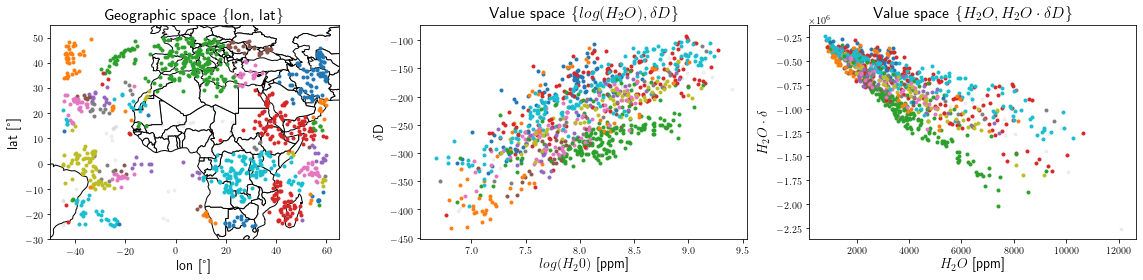

In [22]:
labels = clustering.labels_

df['labels'] = labels

df_sample = df.sample(n=1000, random_state=1)

grouped = df.sample(n=1000, random_state=1).groupby('labels')

matplotlib.rcParams['text.usetex'] = True
fig = plt.figure(figsize=(16, 4), tight_layout=True)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax1 = fig.add_subplot(1, 3, 1) 
ax1.set_title("Geographic space \{lon, lat\}", fontsize=16)
ax1.set_xlabel('lon [\N{DEGREE SIGN}]', fontsize=14)
ax1.set_ylabel('lat [\N{DEGREE SIGN}]', fontsize=14)
ax1.set_xlim(-50,65)
ax1.set_ylim(-30,55)

ax2 = fig.add_subplot(1, 3, 2) 
ax2.set_title(r"Value space $\{log(H_2O), \delta D\}$", fontsize=16)
ax2.set_xlabel(r"$log(H_20)$ [ppm]", fontsize=14)
ax2.set_ylabel(r"$\delta$D", fontsize=14)

ax3 = fig.add_subplot(1, 3, 3) 
ax3.set_title(r"Value space $\{H_2O, H_2O \cdot \delta D\}$", fontsize=16)
ax3.set_xlabel(r"$H_2O$ [ppm]", fontsize=14)
ax3.set_ylabel(r"$H_2O \cdot \delta$ ", fontsize=14)
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for name, group in grouped:
    if name == -1:
        world.plot(ax=ax1, color='white', edgecolor='black')
        ax1.scatter(group.lon, group.lat, marker='.', c='gray', alpha=0.1)
        ax2.scatter(group.h2o_log, group.delD, marker='.', c='gray', alpha=0.1)
        ax3.scatter(group.h2o, group.h2o*group.delD, marker='.', c='gray', alpha=0.1)
    else:
        ax1.scatter(group.lon, group.lat, marker='.')
        ax2.scatter(group.h2o_log, group.delD, marker='.')
        ax3.scatter(group.h2o, group.h2o*group.delD, marker='.')